In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import platform
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from xgboost import plot_importance


from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False
if platform.system() == 'Darwin' :
    rc('font', family() == 'AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Linux':
    path = '/usr/share/fonts/NanumGothic.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
else :
    print('Unknown system')

In [2]:
CATCHER_DF_PATH = 'Desktop/김진한/한국해양대학교/4학년 1학기/캡스톤디자인/캡디 데이터프레임/catcher_df.csv'
TEAM_DF_PATH = 'Desktop/김진한/한국해양대학교/4학년 1학기/캡스톤디자인/캡디 데이터프레임/team_df.csv'
PITCHER_DF_PATH = 'Desktop/김진한/한국해양대학교/4학년 1학기/캡스톤디자인/캡디 데이터프레임/pitcher_df.csv'
CATCH_PITCH_DF_PATH = 'Desktop/김진한/한국해양대학교/4학년 1학기/캡스톤디자인/캡디 데이터프레임/last_df.csv'
#CATCH_PITCH_DF는 투수 데이터에 주전포수,백업포수 정보 포함

# 포수 평균자책점, CERA에 대해서
#### 포수 평균자책점인 CERA과 다른 여러가지 요인들의 관계

### CERA과 팀방어율과의 관계

In [3]:
catcher_df = pd.read_csv(CATCHER_DF_PATH, encoding='cp949',index_col=0)

In [4]:
catcher_df[['CERA', '팀방어율']].corr()

,CERA,팀방어율
CERA,1.000000,0.752203
팀방어율,0.752203,1.000000


C:\Users\USER\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


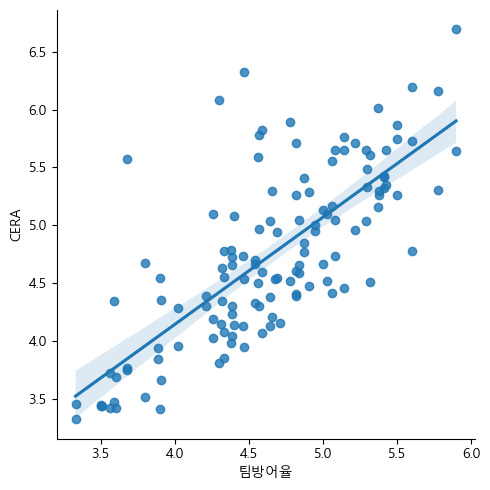

In [5]:
sns.lmplot(x='팀방어율', y='CERA', data=catcher_df)

### CERA과 포수수비 기대득점과의 관계

* cs 는 도루저지와 관련된 포수 기대득점
* blk 는 블로킹과 관련된 포수 기대득점
* frm 은 프레이밍과 관련된 포수 기대득점

<Axes: title={'center': 'CERA과 포수수비 기대득점과의 상관계수'}>

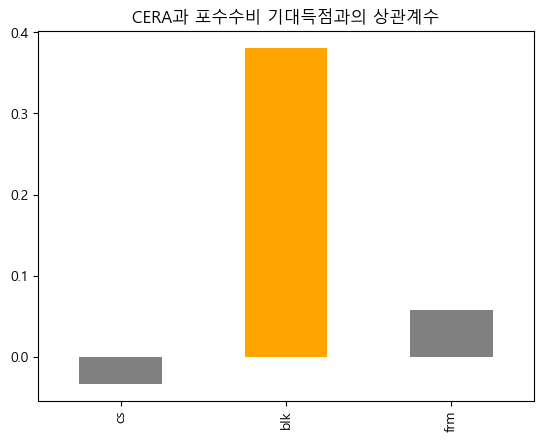

In [6]:
catcher_df['cera'] = (-1) * catcher_df['CERA']
catcher_df[['cera', 'cs', 'blk', 'frm']].corr().iloc[0, 1:].plot(kind='bar', color=['grey', 'orange', 'grey'], title='CERA과 포수수비 기대득점과의 상관계수')

Text(0.5, 1.0, '프레이밍')

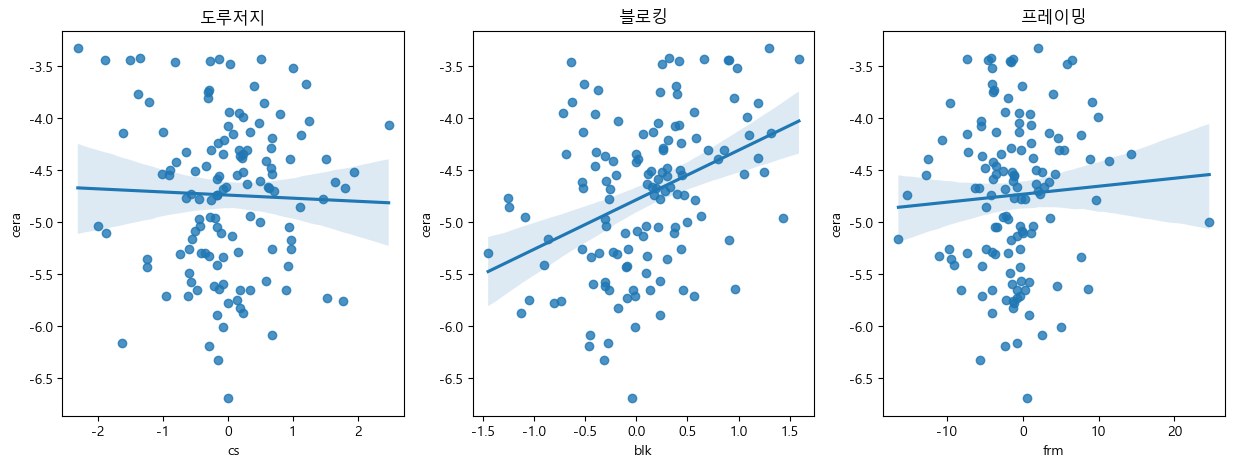

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# 도루저지와 CERA과의 관계
sns.regplot(x='cs', y='cera', data=catcher_df, ax=axes[0])
axes[0].set_title('도루저지')

# 블로킹과 CERA과의 관계
sns.regplot(x='blk', y='cera', data=catcher_df, ax=axes[1])
axes[1].set_title('블로킹')

# 프레이밍과 CERA과의 관계
sns.regplot(x='frm', y='cera', data=catcher_df, ax=axes[2])
axes[2].set_title('프레이밍')

## 머신러닝으로 알아본 cera

### statsmodels의 선형회귀

In [8]:
"""
스케일러는 캡스톤디자인 발표 당시 StandardScaler을 사용했으나 MinMaxScaler을 사용
"""
scaler = MinMaxScaler()
catcher_df['팀방어율-CERA'] = catcher_df['팀방어율'] - catcher_df['CERA']
catcher_df[['cs', 'blk', 'frm', '팀방어율-CERA']] = scaler.fit_transform(catcher_df[['cs', 'blk', 'frm', '팀방어율-CERA']])

In [9]:
X = catcher_df[['cs', 'blk', 'frm']]
y = catcher_df['팀방어율-CERA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              팀방어율-CERA   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     4.090
Date:                Thu, 04 Jan 2024   Prob (F-statistic):            0.00878
Time:                        09:16:09   Log-Likelihood:                 41.155
No. Observations:                 103   AIC:                            -74.31
Df Residuals:                      99   BIC:                            -63.77
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5524      0.074      7.457      0.000       0.405       0.699
cs             0.0417      0.094      0.444      0.658      -0.145       0.228
blk            0.2941      0.085      3.444      0.001       0.125       0.463
frm           -0.1549      0.126     -1.225      0.223      -0.406       0.096
==============================================================================
Omnibus:                        7.613   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                7.295
Skew:                          -0.545   Prob(JB):                       0.0261
Kurtosis:                       3.716   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* 블로킹을 제외한 스탯들은 p-value<0.05로 유의미한 영향을 가지지 않는다

Text(0, 0.5, 'coef')

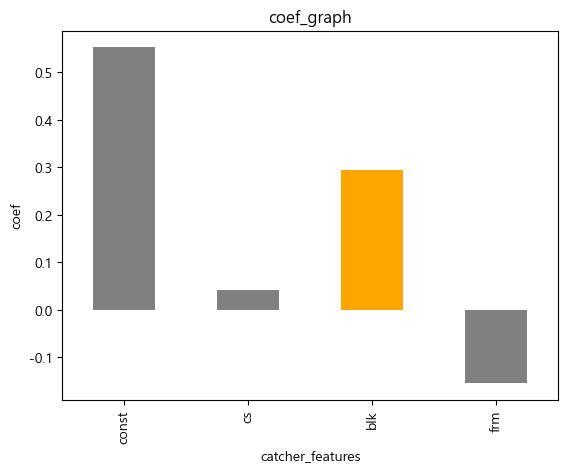

In [10]:
plt = model.params.plot(kind='bar', color=['grey', 'grey', 'orange', 'grey'])
plt.set_title('coef_graph')
plt.set_xlabel('catcher_features')
plt.set_ylabel('coef')

### XGboost 모델 사용

0.11026835671173296


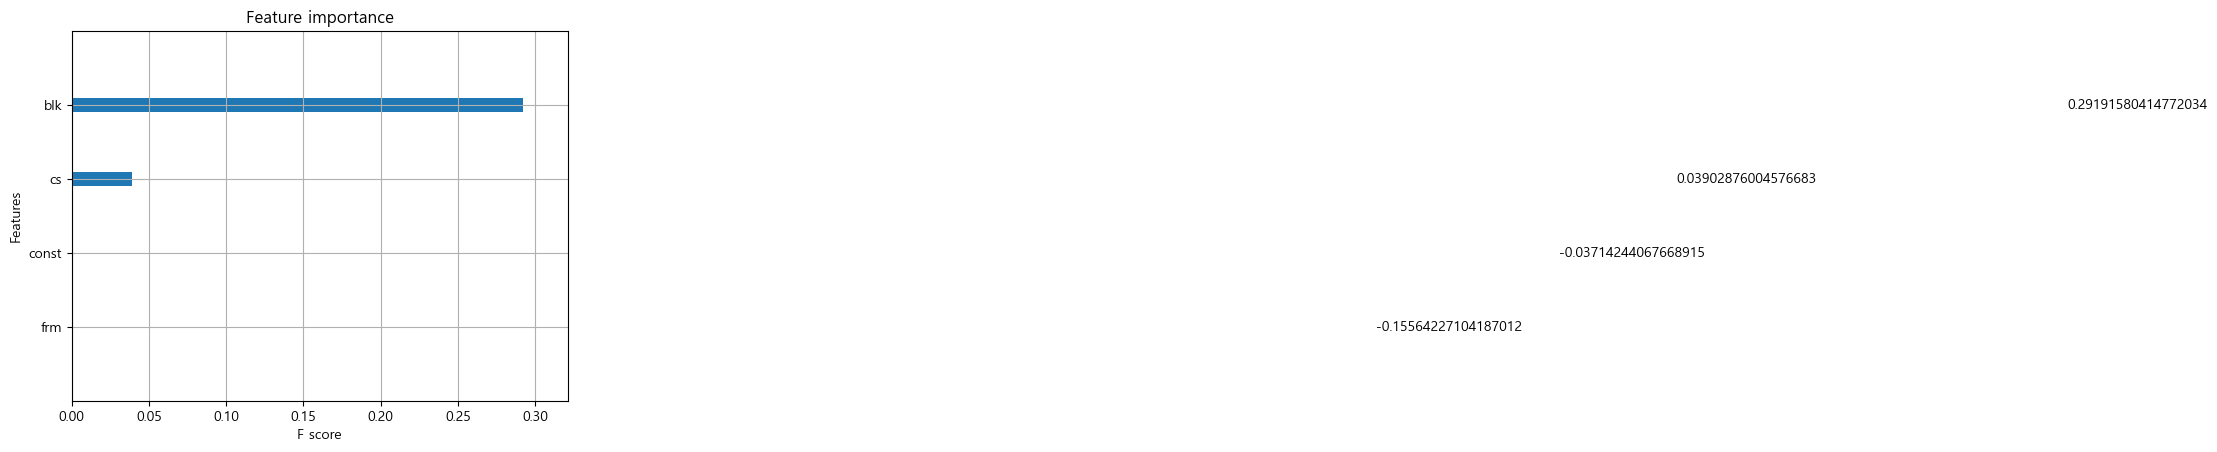

In [11]:
model = XGBRegressor(booster='gblinear')
model.fit(X_train, y_train)
plot_importance(model)
print(model.score(X_train, y_train))

* 모델의 정확도가 너무 낮다

# 팀 수비에 대해서

#### 포수뿐만 아니라 다른 야수들의 수비와 비교, 분석하여 포수의 수비의 중요성 파악

In [12]:
team_df = pd.read_csv(TEAM_DF_PATH, encoding='cp949', index_col=0)

In [13]:
#MinMaxScaler 사용
defense_features = ['cs', 'blk', 'frm', 'IRNG', 'IE+', 'ORNG', 'OARM','OE+', '팀FIP', '팀방어율']

team_df[defense_features + ['타점']] = scaler.fit_transform(team_df[defense_features+['타점']])

In [14]:
# 팀방어율과 팀FIP는 낮을수록 좋은 스탯이므로 음수로 만들어준다

team_df[['팀방어율', '팀FIP']] = (-1) * team_df[['팀방어율', '팀FIP']]

### statsmodels의 OLS 사용

In [15]:
X = team_df[['cs', 'blk', 'frm', 'IRNG', 'IE+', 'ORNG', 'OARM','OE+', '팀FIP']]
y = team_df['팀방어율']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train). fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   팀방어율   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     72.28
Date:                Thu, 04 Jan 2024   Prob (F-statistic):           3.91e-21
Time:                        09:16:10   Log-Likelihood:                 73.009
No. Observations:                  48   AIC:                            -126.0
Df Residuals:                      38   BIC:                            -107.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5347      0.058     -9.144      0.000      -0.653      -0.416
cs             0.0079      0.041      0.190      0.850      -0.076       0.092
blk            0.1469      0.043      3.438      0.001       0.060       0.233
frm           -0.0597      0.045     -1.329      0.192      -0.151       0.031
IRNG           0.2117      0.044      4.765      0.000       0.122       0.302
IE+            0.0834      0.037      2.278      0.028       0.009       0.158
ORNG           0.2745      0.052      5.276      0.000       0.169       0.380
OARM           0.0650      0.040      1.645      0.108      -0.015       0.145
OE+            0.0600      0.042      1.441      0.158      -0.024       0.144
팀FIP           0.7074      0.039     17.956      0.000       0.628       0.787
==============================================================================
Omnibus:                        0.297   Durbin-Watson:                   2.269
Prob(Omnibus):                  0.862   Jarque-Bera (JB):                0.016
Skew:                           0.028   Prob(JB):                        0.992
Kurtosis:                       3.070   Cond. No.                         15.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* 몇몇 변수가 유의미하지 않긴 하지만, 시각화를 해보자

Text(0.5, 1.0, '방어율에 미치는 영향')

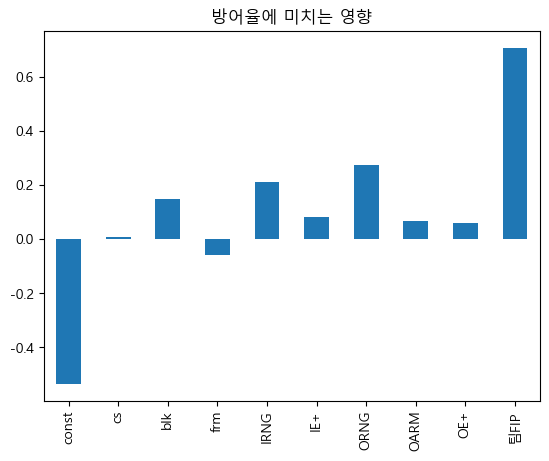

In [16]:
plt = model.params.plot(kind='bar')
plt.set_title('방어율에 미치는 영향')

### xgboost 모델 사용

0.9447720057581386


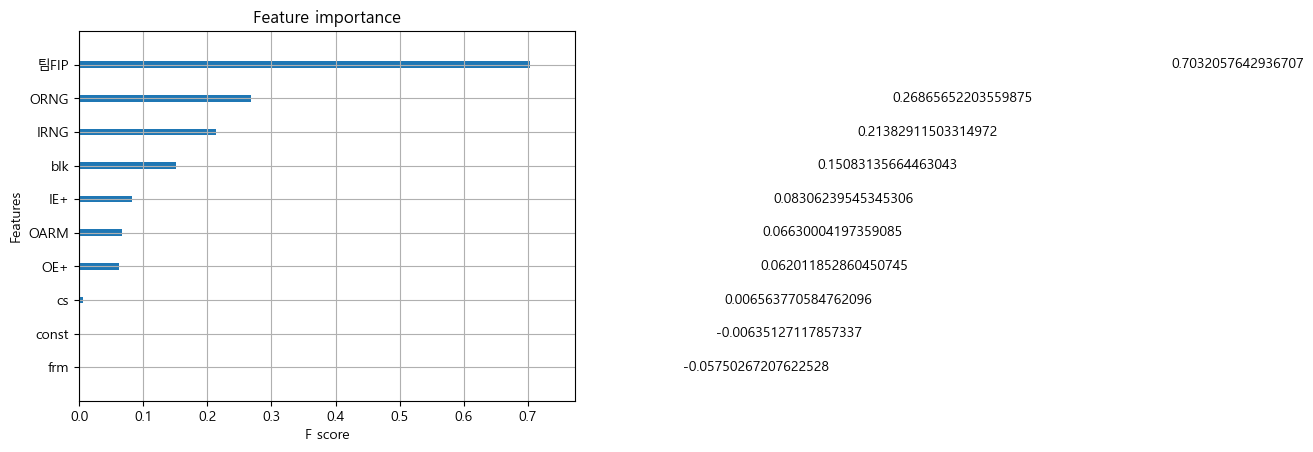

In [17]:
model = XGBRegressor(booster='gblinear')
model.fit(X_train, y_train)
plot_importance(model)
print(model.score(X_train, y_train))

# 수비, 타격, 투구가 승률에 미치는 영향

#### 야구의 요소 중에 포수의 수비는 얼마나 영향을 미칠까를 분석, 파악

In [18]:
team_df['승률'] = scaler.fit_transform(team_df[['승률']])

In [19]:
X = team_df[['cs', 'blk', 'frm', 'IRNG', 'IE+', 'ORNG', 'OARM','OE+', '타점', '팀FIP']]
y = team_df['승률']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train). fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     승률   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     20.63
Date:                Thu, 04 Jan 2024   Prob (F-statistic):           3.19e-12
Time:                        09:16:11   Log-Likelihood:                 48.995
No. Observations:                  48   AIC:                            -75.99
Df Residuals:                      37   BIC:                            -55.41
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1533      0.101      1.520      0.137      -0.051       0.358
cs            -0.0093      0.073     -0.127      0.900      -0.158       0.139
blk            0.0148      0.071      0.208      0.836      -0.129       0.158
frm           -0.0192      0.073     -0.261      0.795      -0.168       0.130
IRNG           0.1192      0.075      1.597      0.119      -0.032       0.270
IE+            0.1701      0.065      2.625      0.013       0.039       0.301
ORNG           0.1831      0.091      2.002      0.053      -0.002       0.368
OARM           0.1834      0.063      2.902      0.006       0.055       0.311
OE+            0.0881      0.072      1.220      0.230      -0.058       0.234
타점             0.7158      0.081      8.849      0.000       0.552       0.880
팀FIP           0.5102      0.069      7.412      0.000       0.371       0.650
==============================================================================
Omnibus:                        1.019   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.601   Jarque-Bera (JB):                1.068
Skew:                           0.305   Prob(JB):                        0.586
Kurtosis:                       2.598   Cond. No.                         17.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, '승률에 미치는 영향')

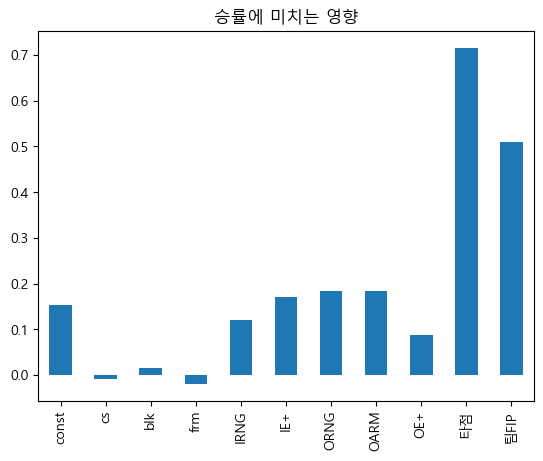

In [20]:
plt = model.params.plot(kind='bar')
plt.set_title('승률에 미치는 영향')

0.8474951295900754


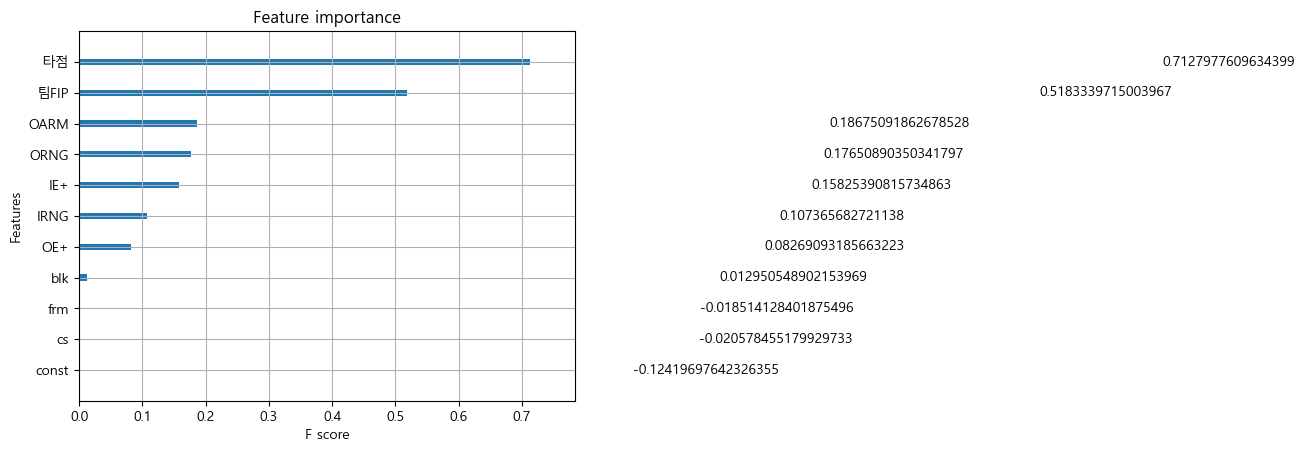

In [21]:
model = XGBRegressor(booster='gblinear')
model.fit(X_train, y_train)
plot_importance(model)
print(model.score(X_train, y_train))

## 포수수비와 FIP의 관계

#### statsmodels의 OLS 사용

In [22]:
X = team_df[['cs', 'blk', 'frm']]
y = team_df['팀FIP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train). fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   팀FIP   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.052
Method:                 Least Squares   F-statistic:                    0.2308
Date:                Thu, 04 Jan 2024   Prob (F-statistic):              0.874
Time:                        09:16:12   Log-Likelihood:                -1.0716
No. Observations:                  48   AIC:                             10.14
Df Residuals:                      44   BIC:                             17.63
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5605      0.159     -3.531      0.001      -0.880      -0.241
cs            -0.0310      0.181     -0.171      0.865      -0.396       0.334
blk            0.1190      0.170      0.698      0.489      -0.225       0.463
frm           -0.0828      0.169     -0.489      0.627      -0.424       0.258
==============================================================================
Omnibus:                        1.741   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.419   Jarque-Bera (JB):                1.319
Skew:                           0.188   Prob(JB):                        0.517
Kurtosis:                       2.280   Cond. No.                         8.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: >

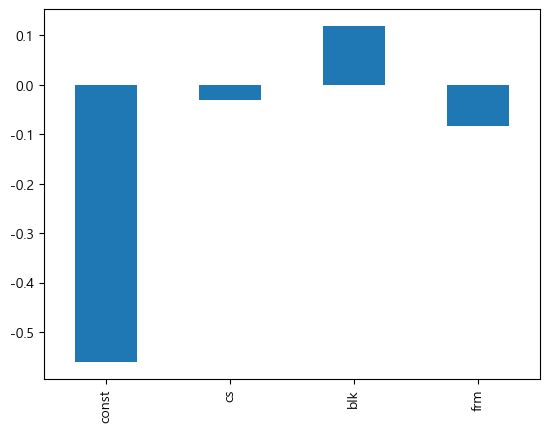

In [23]:
model.params.plot(kind='bar')

### xgboost 모델 사용

0.015493430962144505


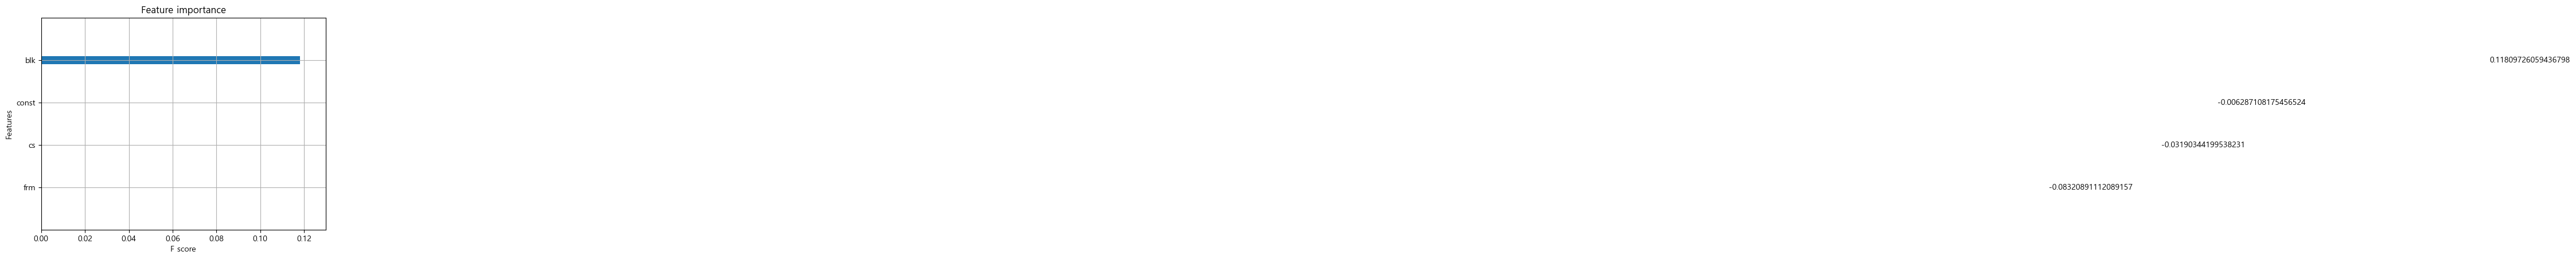

In [24]:
model = XGBRegressor(booster='gblinear')
model.fit(X_train, y_train)
plot_importance(model)
print(model.score(X_train, y_train))

# 투수데이터

#### 투수들은 좌/우, 오버/사이드/언더 등 많은 유형들이 있다
#### 이러한 투수들을 비지도학습인 클러스터링으로 유형을 나눈 뒤,
#### 유형에 따른 포수수비에 대한 영향을 분석, 파악

In [25]:
pitcher_df = pd.read_csv(PITCHER_DF_PATH, encoding='cp949', index_col=['이름', '팀'])

In [26]:
pitcher_df.loc[(pitcher_df['L/R'] == 'L'), 'L/R'] = 1
pitcher_df.loc[(pitcher_df['L/R'] == 'R'), 'L/R'] = 0

pitcher_df = pitcher_df.join(pd.get_dummies(pitcher_df['투구폼']))

### 적절한 K를 구하기 위한 Elbow Method

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

<Axes: >

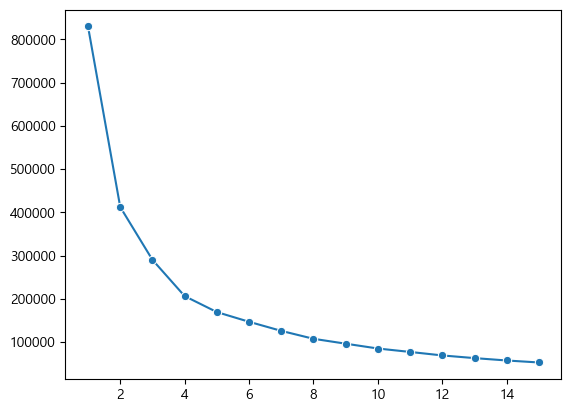

In [27]:
inertias = []
for k in range(1, 16):
    model = KMeans(n_clusters=k, random_state=123)
    model.fit(pitcher_df[['L/R', '사이드암','오버','언더','직구', '기타변화구','종변화구']])
    inertias.append(model.inertia_)
    
sns.lineplot(x=range(1,16), y=inertias, marker='o')

* k는 5로 결정
* 모델 적용 후, label 번호를 붙여주는 작업 진행

In [28]:
model = KMeans(n_clusters=5, random_state=123)
model.fit(pitcher_df[['L/R', '사이드암','오버','언더','직구', '기타변화구','종변화구']])
pitcher_df['label'] = model.predict(pitcher_df[['L/R', '사이드암','오버','언더','직구', '기타변화구','종변화구']])

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: xlabel='label'>

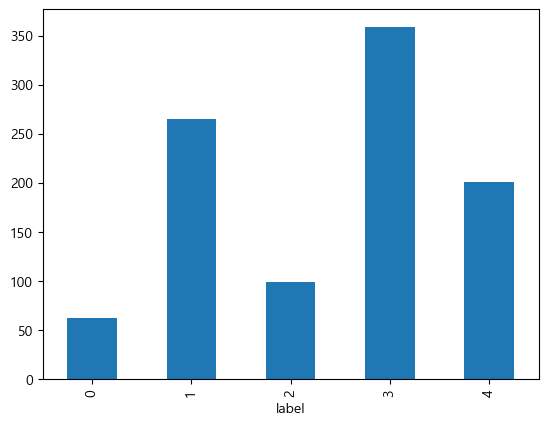

In [29]:
# 각 라벨에 해당되는 선수 수
pitcher_df.groupby('label').size().plot(kind='bar')

In [30]:
display(pitcher_df.groupby('label')[['사이드암','오버','언더','직구', '기타변화구','종변화구']].mean())

display(pitcher_df.groupby('label')[['L/R']].mean())

,사이드암,오버,언더,직구,기타변화구,종변화구
label,,,,,,
0,0.177419,0.709677,0.112903,9.230645,65.791935,24.985484
1,0.075472,0.901887,0.022642,62.474340,4.248302,33.273585
2,0.010101,0.939394,0.050505,17.982828,38.361616,43.657576
3,0.050139,0.908078,0.041783,44.874095,4.777159,50.344847
4,0.144279,0.805970,0.049751,47.906965,27.948756,24.145771


,L/R
label,
0,0.129032
1,0.245283
2,0.10101
3,0.21727
4,0.412935


## 각 라벨의 특징
##### 캡스톤디자인때와 라벨 구성이 조금 달라짐

'라벨 0'
* 사이드암 일부 포함, 직구 구사율이 낮음

'라벨 1'
* 오버핸드 중심, 직구와 종으로 떨어지는 변화구 구사율이 높음

'라벨 2'
* 오버핸드 중심, 직구보다는 다른 변화구 중심

'라벨 3'
* 오버핸드 중심, 직구와 종으로 떨어지는 변화구 구사율이 높음

'라벨 4'
* 사이드암 일부 포함, 직구 구사율이 높음, 좌완 비율이 높음

In [31]:
pitcher_df.loc[(pitcher_df['L/R'] == 1), 'L/R'] = 'L'
pitcher_df.loc[(pitcher_df['L/R'] == 0), 'L/R'] = 'R'

#### 좌/우완, 투구폼 별 선수 수

Text(0.5, 1.0, '투구폼')

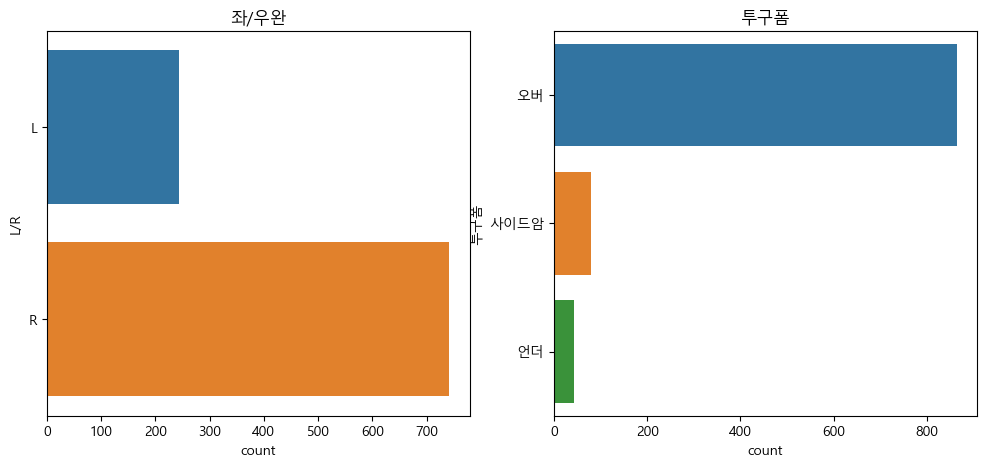

In [32]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(y='L/R', data=pitcher_df, ax=axes[0])
axes[0].set_title('좌/우완')

sns.countplot(y='투구폼', data=pitcher_df, ax=axes[1])
axes[1].set_title('투구폼')

#### 라벨 별 구종 구사율, 좌/우완, 투구폼

C:\Users\USER\AppData\Local\Temp\ipykernel_34804\1128947828.py:3: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(y=pitcher_df['직구'], x=pitcher_df['label'], palette='Set1', ax=axes[0])
C:\Users\USER\AppData\Local\Temp\ipykernel_34804\1128947828.py:6: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(y=pitcher_df['종변화구'], x=pitcher_df['label'], palette='Set2', ax=axes[1])
C:\Users\USER\AppData\Local\Temp\ipykernel_34804\1128947828.py:9: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(y=pitcher_df['기타변화구'], x=pitcher_df['label'], palette='Set3', ax=axes[2])


Text(0.5, 1.0, '기타변화구 구사율')

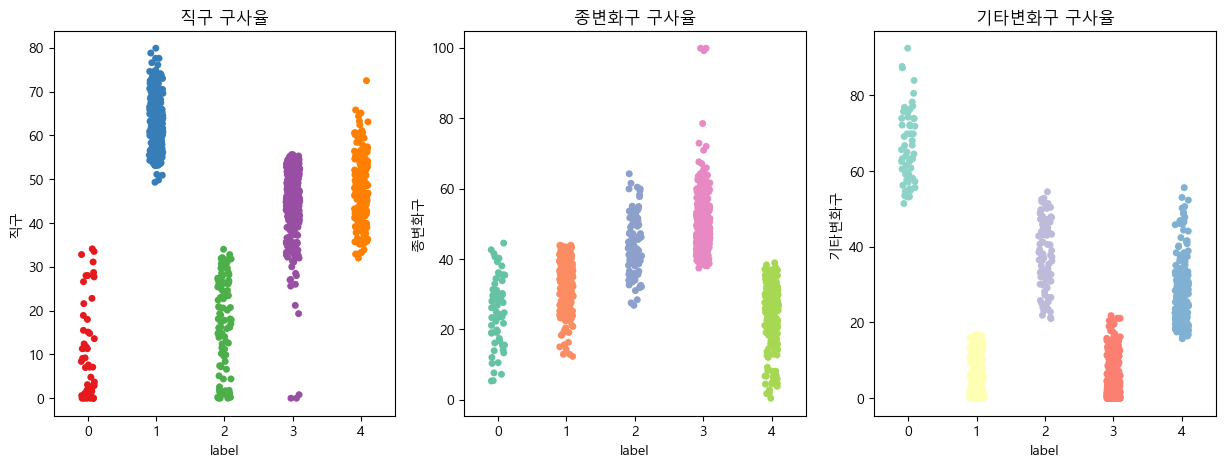

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.stripplot(y=pitcher_df['직구'], x=pitcher_df['label'], palette='Set1', ax=axes[0])
axes[0].set_title('직구 구사율')

sns.stripplot(y=pitcher_df['종변화구'], x=pitcher_df['label'], palette='Set2', ax=axes[1])
axes[1].set_title('종변화구 구사율')

sns.stripplot(y=pitcher_df['기타변화구'], x=pitcher_df['label'], palette='Set3', ax=axes[2])
axes[2].set_title('기타변화구 구사율')

<Axes: xlabel='label', ylabel='count'>

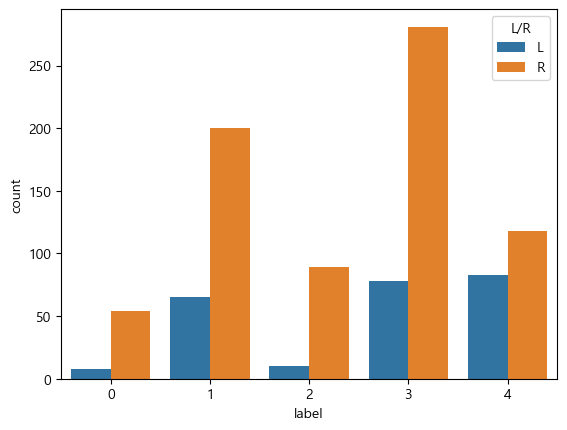

In [34]:
sns.countplot(x=pitcher_df['label'], hue=pitcher_df['L/R'])

<Axes: xlabel='label', ylabel='count'>

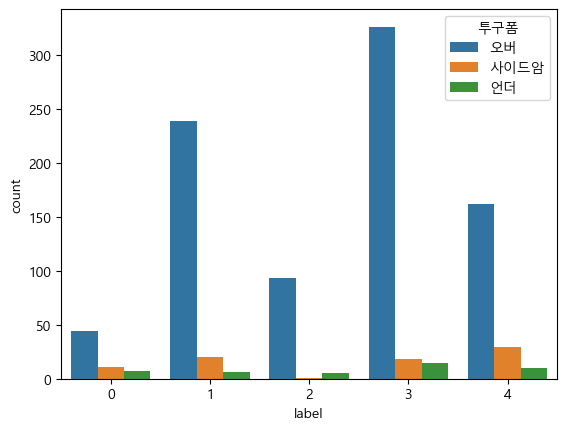

In [35]:
sns.countplot(x=pitcher_df['label'], hue=pitcher_df['투구폼'])

### 라벨 별로 데이터프레임 생성

In [36]:
label_dfs = {}

for label_value in range(5):
    label_dfs[f'label_{label_value}'] = pitcher_df.loc[pitcher_df['label'] == label_value]
    
label_0 = label_dfs['label_0']
label_1 = label_dfs['label_1']
label_2 = label_dfs['label_2']
label_3 = label_dfs['label_3']
label_4 = label_dfs['label_4']

C:\Users\USER\AppData\Local\Temp\ipykernel_34804\4292517272.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label_0['직구'], kde=False, label='직구', ax=axes[0])
C:\Users\USER\AppData\Local\Temp\ipykernel_34804\4292517272.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label_0['종변화구'], kde=F

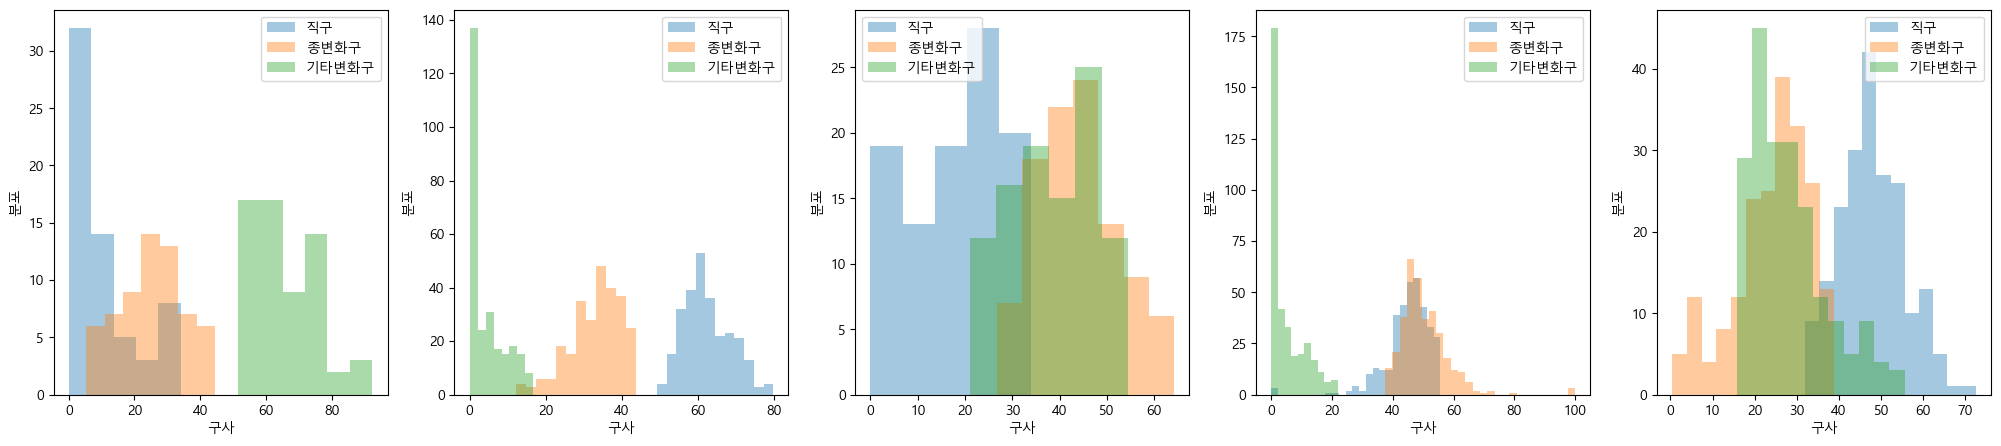

In [37]:
fig, axes = plt.subplots(1,5,figsize=(25,5))

sns.distplot(label_0['직구'], kde=False, label='직구', ax=axes[0])
sns.distplot(label_0['종변화구'], kde=False, label='종변화구', ax=axes[0])
sns.distplot(label_0['기타변화구'], kde=False, label='기타변화구', ax=axes[0])

axes[0].set_xlabel('구사')
axes[0].set_ylabel('분포')
axes[0].legend()

sns.distplot(label_1['직구'], kde=False, label='직구', ax=axes[1])
sns.distplot(label_1['종변화구'], kde=False, label='종변화구', ax=axes[1])
sns.distplot(label_1['기타변화구'], kde=False, label='기타변화구', ax=axes[1])

axes[1].set_xlabel('구사')
axes[1].set_ylabel('분포')
axes[1].legend()

sns.distplot(label_2['직구'], kde=False, label='직구', ax=axes[2])
sns.distplot(label_2['종변화구'], kde=False, label='종변화구', ax=axes[2])
sns.distplot(label_2['기타변화구'], kde=False, label='기타변화구', ax=axes[2])

axes[2].set_xlabel('구사')
axes[2].set_ylabel('분포')
axes[2].legend()

sns.distplot(label_3['직구'], kde=False, label='직구', ax=axes[3])
sns.distplot(label_3['종변화구'], kde=False, label='종변화구', ax=axes[3])
sns.distplot(label_3['기타변화구'], kde=False, label='기타변화구', ax=axes[3])

axes[3].set_xlabel('구사')
axes[3].set_ylabel('분포')
axes[3].legend()

sns.distplot(label_4['직구'], kde=False, label='직구', ax=axes[4])
sns.distplot(label_4['종변화구'], kde=False, label='종변화구', ax=axes[4])
sns.distplot(label_4['기타변화구'], kde=False, label='기타변화구', ax=axes[4])

axes[4].set_xlabel('구사')
axes[4].set_ylabel('분포')
axes[4].legend()

plt.show()

## 데이터 전처리

In [38]:
pitcher_df['볼넷/9'] = (pitcher_df['볼넷']) / (pitcher_df['이닝']) * 9
pitcher_df['K/9'] = (pitcher_df['삼진'])/ (pitcher_df['이닝']) * 9
pitcher_df['E-F'] = pitcher_df['ERA'] - pitcher_df['FIP']
pitcher_df['폭투/9'] = (pitcher_df['폭투']) / (pitcher_df['이닝']) * 9
pitcher_df['포수의기대득점'] = pitcher_df['cs'] + pitcher_df['blk'] + pitcher_df['frm']

features = ['cs', 'blk', 'frm', '볼넷/9', 'K/9', 'E-F', '폭투/9', 'ERA', 'WHIP', 'IRNG', 'IE+', 'ORNG',
           'OARM', 'OE+', 'FIP', 'WAR', '포수의기대득점']

pitcher_df[features] = scaler.fit_transform(pitcher_df[features])

pitcher_df[['볼넷/9', 'E-F', '폭투/9', 'ERA', 'WHIP', 'FIP']] = (-1) * pitcher_df[['볼넷/9', 'E-F', '폭투/9', 'ERA', 'WHIP', 'FIP']]

In [39]:
label_dfs = {}

for label_value in range(5):
    label_dfs[f'label_{label_value}'] = pitcher_df.loc[pitcher_df['label'] == label_value]
    
label_0 = label_dfs['label_0']
label_1 = label_dfs['label_1']
label_2 = label_dfs['label_2']
label_3 = label_dfs['label_3']
label_4 = label_dfs['label_4']

## 투수 유형별 분석, 파악

'라벨 0'
* 사이드암 일부 포함, 직구 구사율이 낮음

<Axes: >

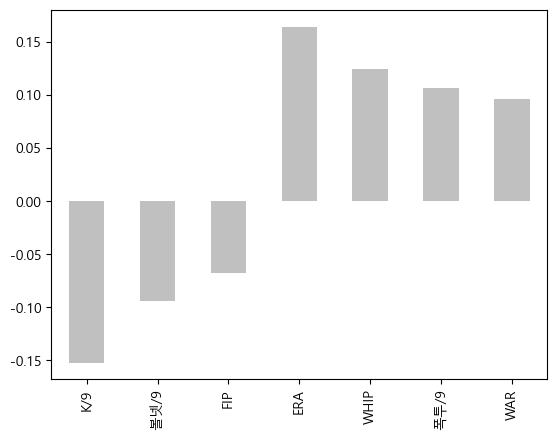

In [40]:
label_0[['blk', 'K/9', '볼넷/9', 'FIP', 'ERA', 'WHIP', '폭투/9', 'WAR']].corr().iloc[0,1:].plot(kind='bar', color='silver')

'라벨 1'
* 오버핸드 중심, 직구와 종으로 떨어지는 변화구 구사율이 높음

<Axes: >

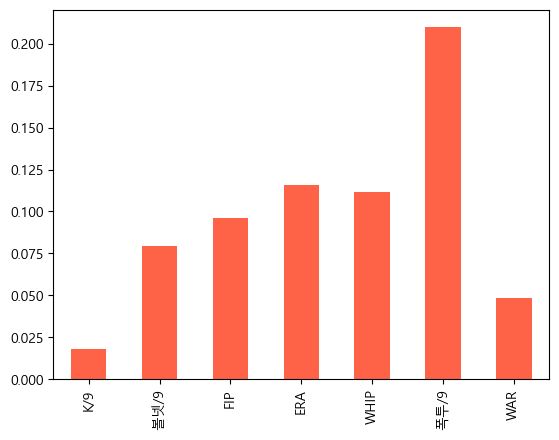

In [41]:
label_1[['blk', 'K/9', '볼넷/9', 'FIP', 'ERA', 'WHIP', '폭투/9', 'WAR']].corr().iloc[0,1:].plot(kind='bar', color='tomato')

'라벨 2'
* 오버핸드 중심, 직구보다는 다른 변화구 중심

<Axes: >

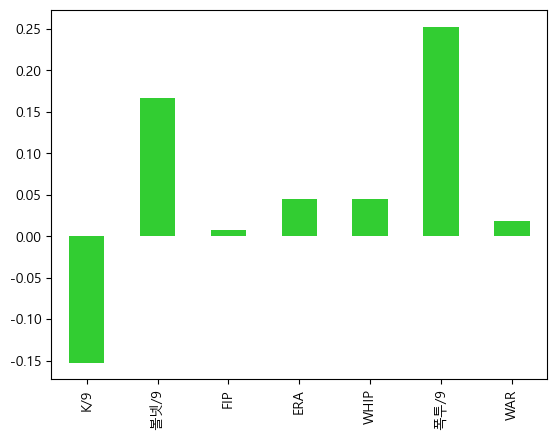

In [42]:
label_2[['blk', 'K/9', '볼넷/9', 'FIP', 'ERA', 'WHIP', '폭투/9', 'WAR']].corr().iloc[0,1:].plot(kind='bar', color='limegreen')

'라벨 3'
* 오버핸드 중심, 직구와 종으로 떨어지는 변화구 구사율이 높음

<Axes: >

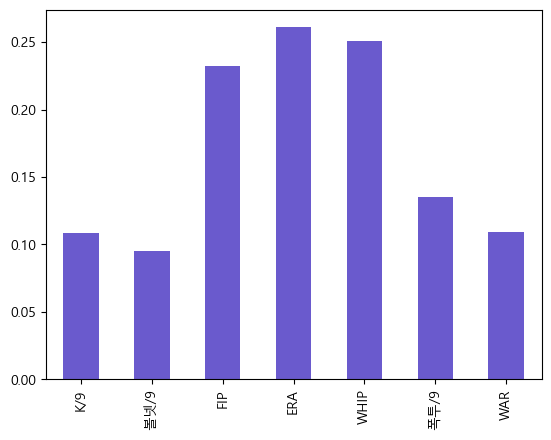

In [43]:
label_4[['blk', 'K/9', '볼넷/9', 'FIP', 'ERA', 'WHIP', '폭투/9', 'WAR']].corr().iloc[0,1:].plot(kind='bar', color='slateblue')

<Axes: >

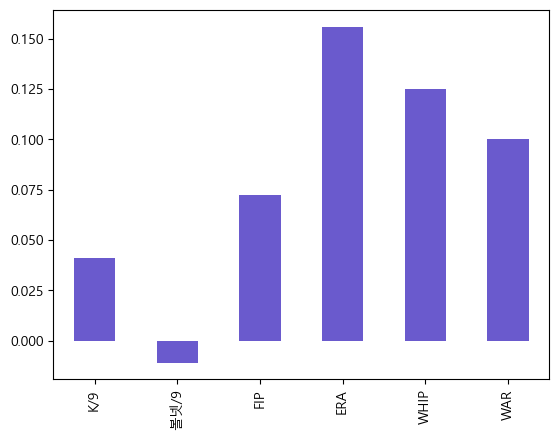

In [44]:
label_4[['frm', 'K/9', '볼넷/9', 'FIP', 'ERA', 'WHIP', 'WAR']].corr().iloc[0,1:].plot(kind='bar', color='slateblue')

'라벨 4'
* 사이드암 일부 포함, 직구 구사율이 높음, 좌완 비율이 높음

<Axes: >

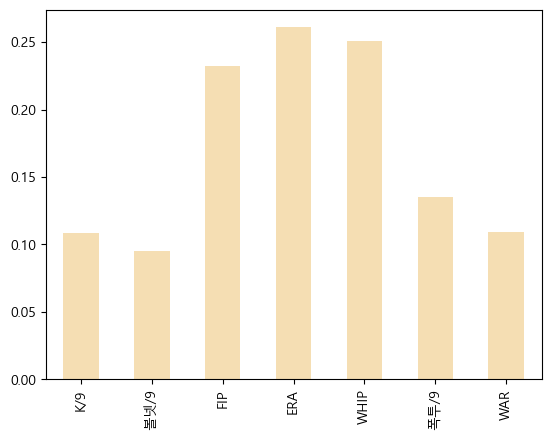

In [45]:
label_4[['blk', 'K/9', '볼넷/9', 'FIP', 'ERA', 'WHIP', '폭투/9', 'WAR']].corr().iloc[0,1:].plot(kind='bar', color='wheat')

## 라벨 별, 수비가 투수성적에 미치는 영향

#### statsmodels.OLS

* 라벨0

In [46]:
X = label_0[['cs', 'blk', 'frm', 'IRNG', 'IE+', 'ORNG', 'OARM','OE+', 'FIP']]
y = label_0['ERA']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train). fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ERA   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     4.575
Date:                Thu, 04 Jan 2024   Prob (F-statistic):           0.000372
Time:                        09:16:37   Log-Likelihood:                 52.144
No. Observations:                  49   AIC:                            -84.29
Df Residuals:                      39   BIC:                            -65.37
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1977      0.104     -1.901      0.065      -0.408       0.013
cs             0.1219      0.084      1.459      0.153      -0.047       0.291
blk            0.0381      0.098      0.390      0.699      -0.159       0.236
frm           -0.0261      0.066     -0.398      0.693      -0.159       0.106
IRNG           0.0388      0.090      0.429      0.670      -0.144       0.222
IE+           -0.0496      0.070     -0.712      0.480      -0.191       0.091
ORNG           0.1893      0.102      1.847      0.072      -0.018       0.397
OARM          -0.0032      0.067     -0.048      0.962      -0.138       0.132
OE+           -0.1026      0.089     -1.152      0.256      -0.283       0.077
FIP            0.5220      0.115      4.526      0.000       0.289       0.755
==============================================================================
Omnibus:                        1.668   Durbin-Watson:                   2.558
Prob(Omnibus):                  0.434   Jarque-Bera (JB):                0.909
Skew:                           0.287   Prob(JB):                        0.635
Kurtosis:                       3.341   Cond. No.                         21.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.5124753914202083


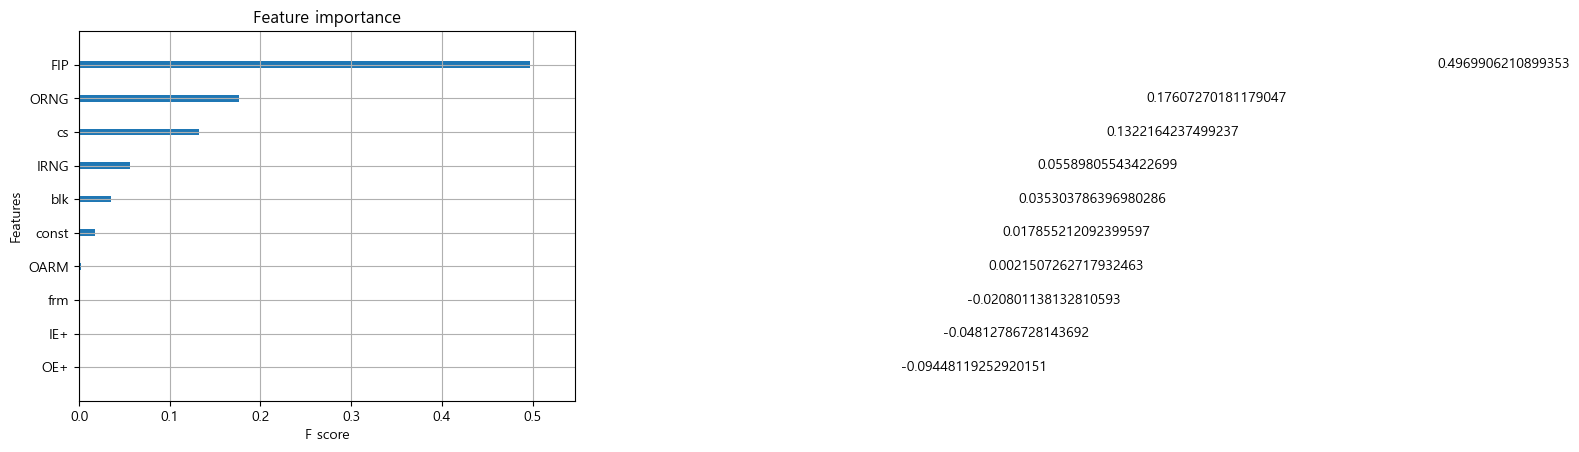

In [47]:
model = XGBRegressor(booster='gblinear')
model.fit(X_train, y_train)
plot_importance(model)
print(model.score(X_train, y_train))

* 라벨 1

In [48]:
X = label_1[['cs', 'blk', 'frm', 'IRNG', 'IE+', 'ORNG', 'OARM','OE+', 'FIP']]
y = label_1['ERA']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train). fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ERA   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     23.12
Date:                Thu, 04 Jan 2024   Prob (F-statistic):           8.00e-27
Time:                        09:16:37   Log-Likelihood:                 168.54
No. Observations:                 212   AIC:                            -317.1
Df Residuals:                     202   BIC:                            -283.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1844      0.049     -3.740      0.000      -0.282      -0.087
cs            -0.0016      0.037     -0.044      0.965      -0.075       0.071
blk           -0.0266      0.037     -0.718      0.474      -0.099       0.046
frm           -0.0314      0.042     -0.752      0.453      -0.114       0.051
IRNG           0.0711      0.039      1.839      0.067      -0.005       0.147
IE+           -0.0043      0.035     -0.124      0.901      -0.073       0.064
ORNG           0.0953      0.050      1.899      0.059      -0.004       0.194
OARM           0.0331      0.036      0.933      0.352      -0.037       0.103
OE+            0.0601      0.041      1.463      0.145      -0.021       0.141
FIP            0.5637      0.043     13.214      0.000       0.480       0.648
==============================================================================
Omnibus:                        3.680   Durbin-Watson:                   2.175
Prob(Omnibus):                  0.159   Jarque-Bera (JB):                3.299
Skew:                          -0.288   Prob(JB):                        0.192
Kurtosis:                       3.206   Cond. No.                         14.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.5070827287338044


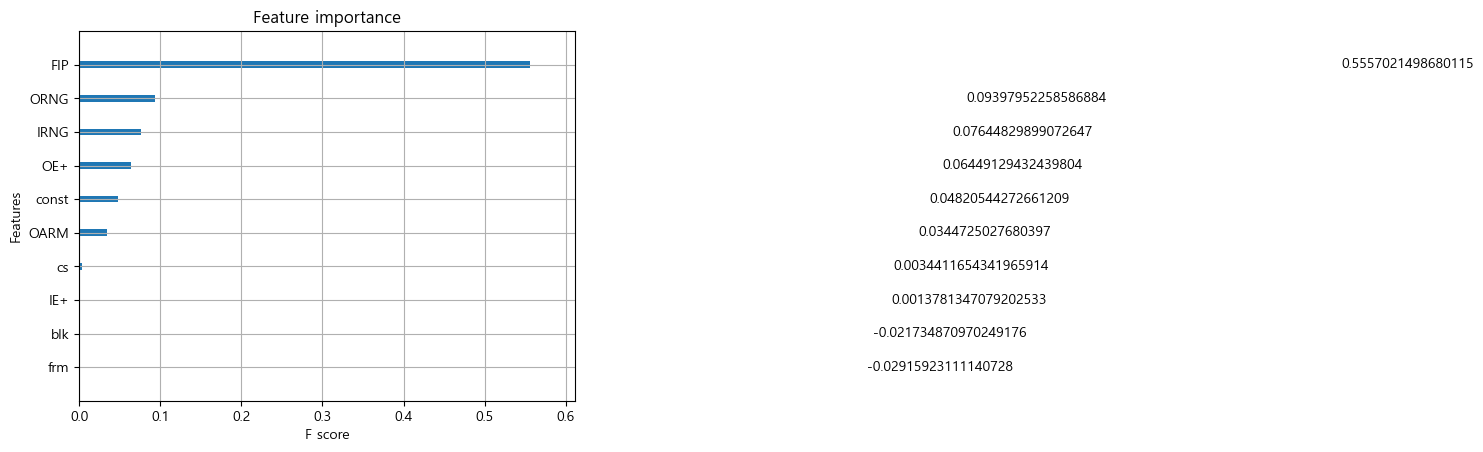

In [49]:
model = XGBRegressor(booster='gblinear')
model.fit(X_train, y_train)
plot_importance(model)
print(model.score(X_train, y_train))

* 라벨 2

In [50]:
X = label_2[['cs', 'blk', 'frm', 'IRNG', 'IE+', 'ORNG', 'OARM','OE+', 'FIP']]
y = label_2['ERA']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train). fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ERA   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     12.32
Date:                Thu, 04 Jan 2024   Prob (F-statistic):           2.22e-11
Time:                        09:16:38   Log-Likelihood:                 90.688
No. Observations:                  79   AIC:                            -161.4
Df Residuals:                      69   BIC:                            -137.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0860      0.075     -1.147      0.255      -0.236       0.064
cs            -0.0059      0.057     -0.103      0.918      -0.120       0.108
blk            0.0368      0.047      0.789      0.433      -0.056       0.130
frm           -0.0379      0.051     -0.741      0.461      -0.140       0.064
IRNG           0.0475      0.053      0.898      0.372      -0.058       0.153
IE+           -0.0205      0.046     -0.442      0.660      -0.113       0.072
ORNG           0.0880      0.065      1.362      0.178      -0.041       0.217
OARM          -0.0978      0.042     -2.327      0.023      -0.182      -0.014
OE+            0.0049      0.048      0.102      0.919      -0.092       0.102
FIP            0.6345      0.073      8.648      0.000       0.488       0.781
==============================================================================
Omnibus:                        0.744   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.689   Jarque-Bera (JB):                0.620
Skew:                          -0.215   Prob(JB):                        0.734
Kurtosis:                       2.937   Cond. No.                         19.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.615499466294505


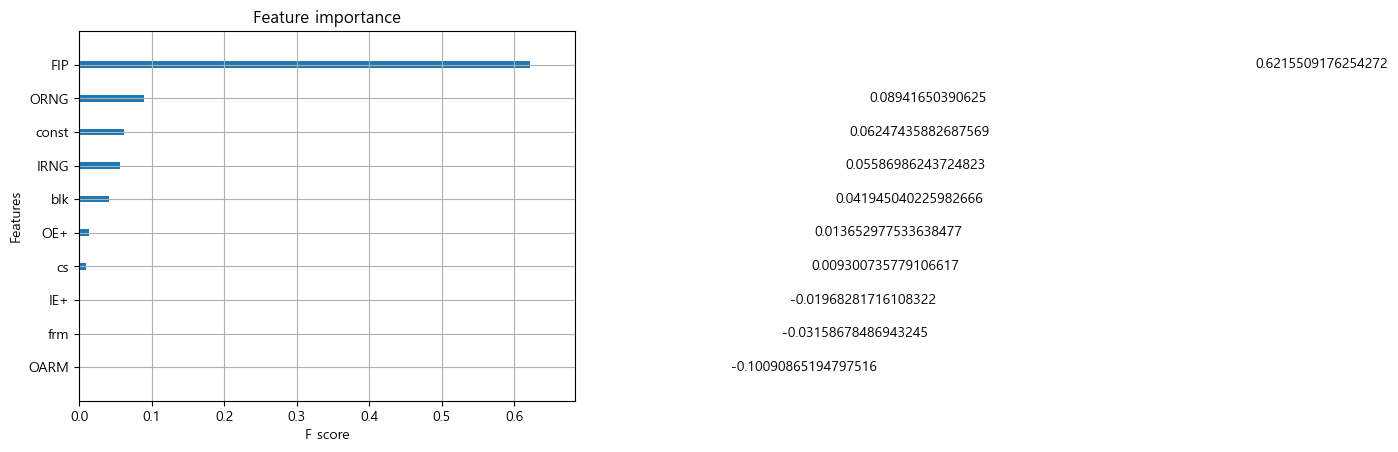

In [51]:
model = XGBRegressor(booster='gblinear')
model.fit(X_train, y_train)
plot_importance(model)
print(model.score(X_train, y_train))

* 라벨 3

In [52]:
X = label_3[['cs', 'blk', 'frm', 'IRNG', 'IE+', 'ORNG', 'OARM','OE+', 'FIP']]
y = label_3['ERA']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train). fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ERA   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     37.59
Date:                Thu, 04 Jan 2024   Prob (F-statistic):           3.52e-43
Time:                        09:16:39   Log-Likelihood:                 260.25
No. Observations:                 287   AIC:                            -500.5
Df Residuals:                     277   BIC:                            -463.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1528      0.037     -4.136      0.000      -0.226      -0.080
cs             0.0306      0.030      1.030      0.304      -0.028       0.089
blk            0.0163      0.029      0.558      0.577      -0.041       0.074
frm           -0.0515      0.031     -1.658      0.098      -0.113       0.010
IRNG           0.0610      0.031      1.981      0.049       0.000       0.122
IE+            0.0198      0.027      0.744      0.458      -0.033       0.072
ORNG           0.1026      0.037      2.741      0.007       0.029       0.176
OARM           0.0310      0.027      1.132      0.258      -0.023       0.085
OE+           -0.0212      0.029     -0.724      0.470      -0.079       0.036
FIP            0.6581      0.037     17.588      0.000       0.584       0.732
==============================================================================
Omnibus:                       17.111   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.494
Skew:                          -0.576   Prob(JB):                     9.64e-05
Kurtosis:                       3.467   Cond. No.                         15.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.5488368381480411


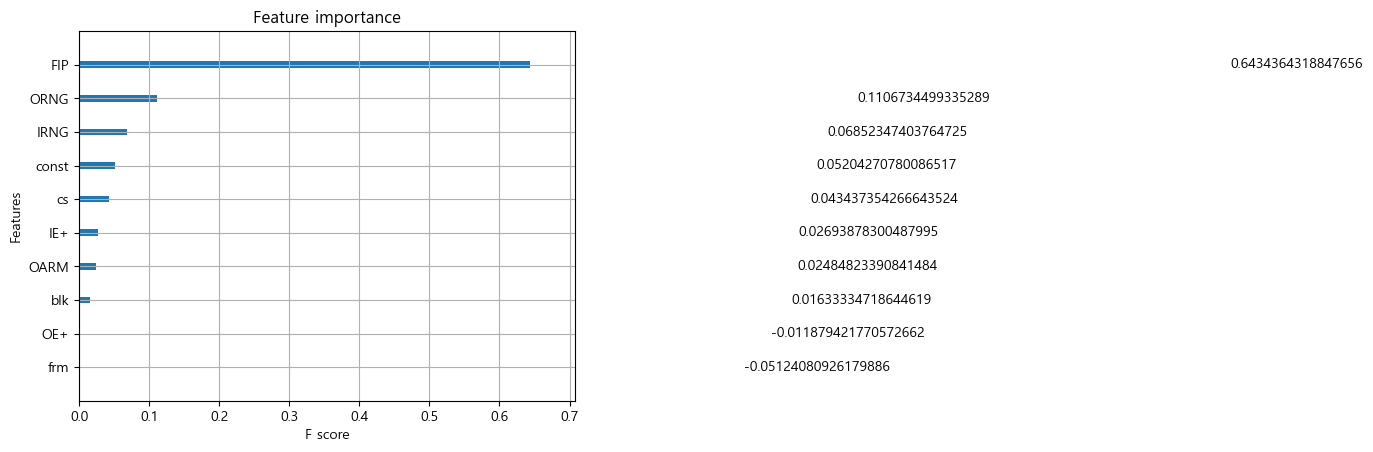

In [53]:
model = XGBRegressor(booster='gblinear')
model.fit(X_train, y_train)
plot_importance(model)
print(model.score(X_train, y_train))

* 라벨 4

In [54]:
X = label_4[['cs', 'blk', 'frm', 'IRNG', 'IE+', 'ORNG', 'OARM','OE+', 'FIP']]
y = label_4['ERA']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train). fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ERA   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     27.48
Date:                Thu, 04 Jan 2024   Prob (F-statistic):           1.27e-27
Time:                        09:16:39   Log-Likelihood:                 154.50
No. Observations:                 160   AIC:                            -289.0
Df Residuals:                     150   BIC:                            -258.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0539      0.052     -1.046      0.297      -0.156       0.048
cs            -0.0340      0.036     -0.951      0.343      -0.105       0.037
blk            0.0328      0.037      0.897      0.371      -0.039       0.105
frm            0.0271      0.039      0.695      0.488      -0.050       0.104
IRNG          -0.0131      0.036     -0.362      0.718      -0.085       0.058
IE+           -0.0156      0.034     -0.453      0.651      -0.083       0.052
ORNG           0.0271      0.046      0.587      0.558      -0.064       0.118
OARM           0.0508      0.036      1.403      0.163      -0.021       0.122
OE+            0.0040      0.038      0.106      0.916      -0.071       0.079
FIP            0.7116      0.050     14.256      0.000       0.613       0.810
==============================================================================
Omnibus:                        3.097   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.213   Jarque-Bera (JB):                3.236
Skew:                           0.089   Prob(JB):                        0.198
Kurtosis:                       3.674   Cond. No.                         16.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.6192611627840163


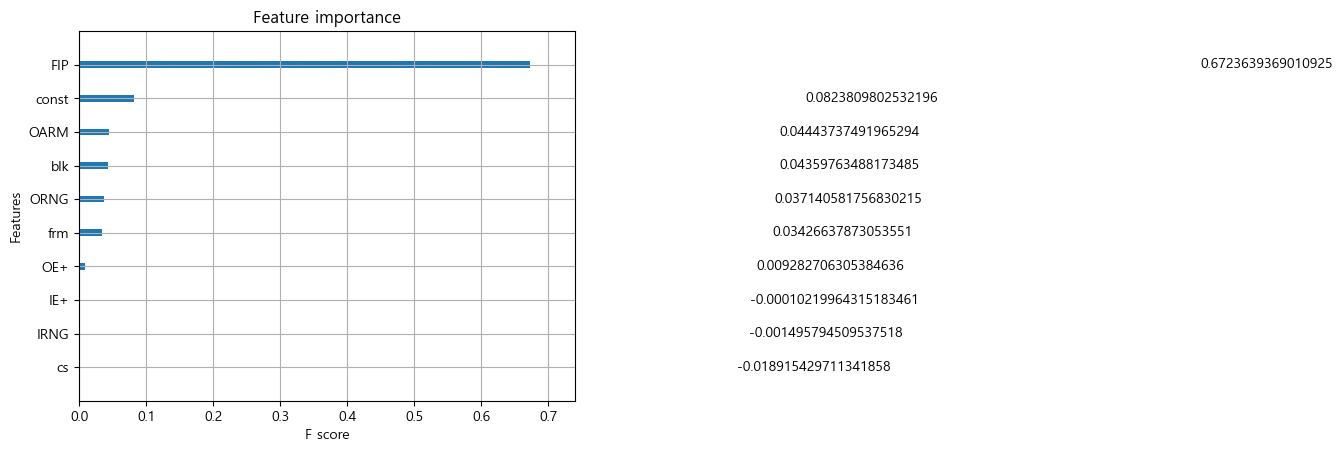

In [55]:
model = XGBRegressor(booster='gblinear')
model.fit(X_train, y_train)
plot_importance(model)
print(model.score(X_train, y_train))

## 포수에 따른 투수 방어율 영향

In [56]:
catch_pitch_df = pd.read_csv(CATCH_PITCH_DF_PATH, encoding='cp949', index_col=0)

#### 전처리

In [57]:
catch_pitch_df = catch_pitch_df.join(pd.get_dummies(catch_pitch_df[['주전포수', '백업포수']]))

catch_pitch_df['K/9'] = catch_pitch_df['삼진'] / catch_pitch_df['이닝'] * 9
catch_pitch_df['볼넷/9'] = catch_pitch_df['볼넷'] / catch_pitch_df['이닝'] * 9
catch_pitch_df['폭투/9'] = catch_pitch_df['폭투'] / catch_pitch_df['이닝'] * 9
catch_pitch_df['E-F'] = catch_pitch_df['ERA'] - catch_pitch_df['FIP']

In [58]:
feature_list = ['cs', 'blk', 'frm', '볼넷/9', 'K/9', '폭투/9', 'ERA', 'WHIP', 'IRNG', 'IE+', 'ORNG', 'OARM', 'OE+', 'FIP', 'WAR', 'E-F']

catch_pitch_df[feature_list] = scaler.fit_transform(catch_pitch_df[feature_list])

catch_pitch_df[['볼넷/9', '폭투/9', 'ERA', 'WHIP', 'FIP']] = (-1) * catch_pitch_df[['볼넷/9', '폭투/9', 'ERA', 'WHIP', 'FIP']]

In [59]:
#주전포수 추출
catch_pitch_df2 = catch_pitch_df.loc[(catch_pitch_df['주전포수_강민호'] == 1) | (catch_pitch_df['주전포수_김민식'] == 1) | (catch_pitch_df['주전포수_나종덕'] == 1) | (catch_pitch_df['주전포수_박동원'] == 1) | (catch_pitch_df['주전포수_박세혁'] == 1) | (catch_pitch_df['주전포수_양의지'] == 1) | (catch_pitch_df['주전포수_유강남'] == 1) | (catch_pitch_df['주전포수_이재원'] == 1) | (catch_pitch_df['주전포수_이지영'] == 1)]

0.5343733138330371


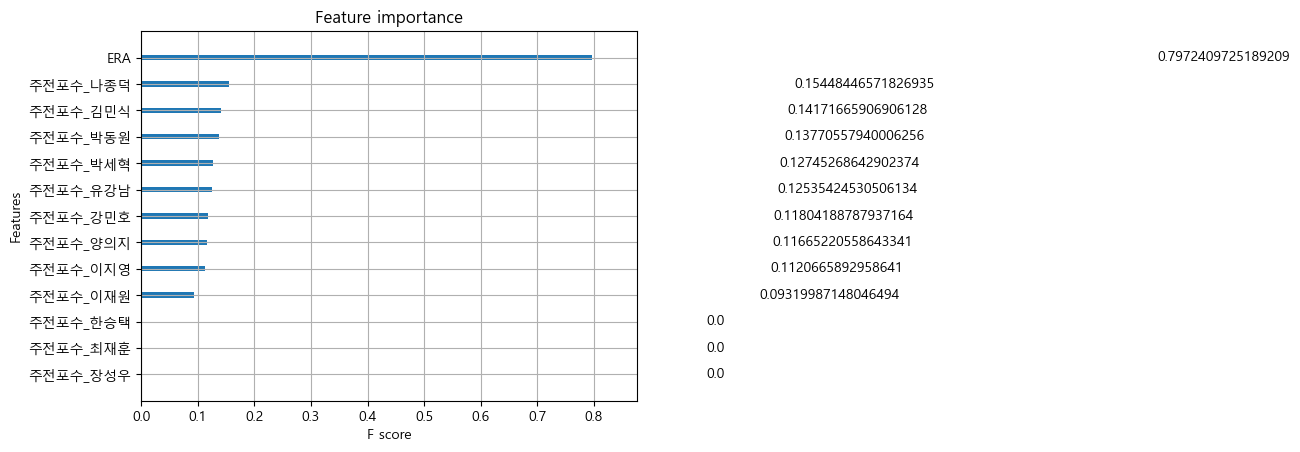

In [60]:
X = catch_pitch_df2[['주전포수_강민호', '주전포수_김민식' ,'주전포수_나종덕', '주전포수_박동원', '주전포수_박세혁' ,'주전포수_양의지', '주전포수_유강남', '주전포수_이재원', '주전포수_이지영', '주전포수_장성우', '주전포수_최재훈', '주전포수_한승택', 'ERA']]
y = catch_pitch_df2['FIP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
model = XGBRegressor(booster='gblinear')
model.fit(X_train, y_train)
plot_importance(model)
print(model.score(X_train, y_train))

In [61]:
catch_pitch_0 = catch_pitch_df2.loc[(catch_pitch_df2['label']==0)]
catch_pitch_1 = catch_pitch_df2.loc[(catch_pitch_df2['label']==1)]
catch_pitch_2 = catch_pitch_df2.loc[(catch_pitch_df2['label']==2)]
catch_pitch_3 = catch_pitch_df2.loc[(catch_pitch_df2['label']==3)]
catch_pitch_4 = catch_pitch_df2.loc[(catch_pitch_df2['label']==4)]

[0.11609   0.176264  0.175426  0.149982  0.151601  0.0831088 0.130479
 0.111278  0.0845909 0.        0.        0.        0.767438 ]
[0.132089]
0.48729685851188864


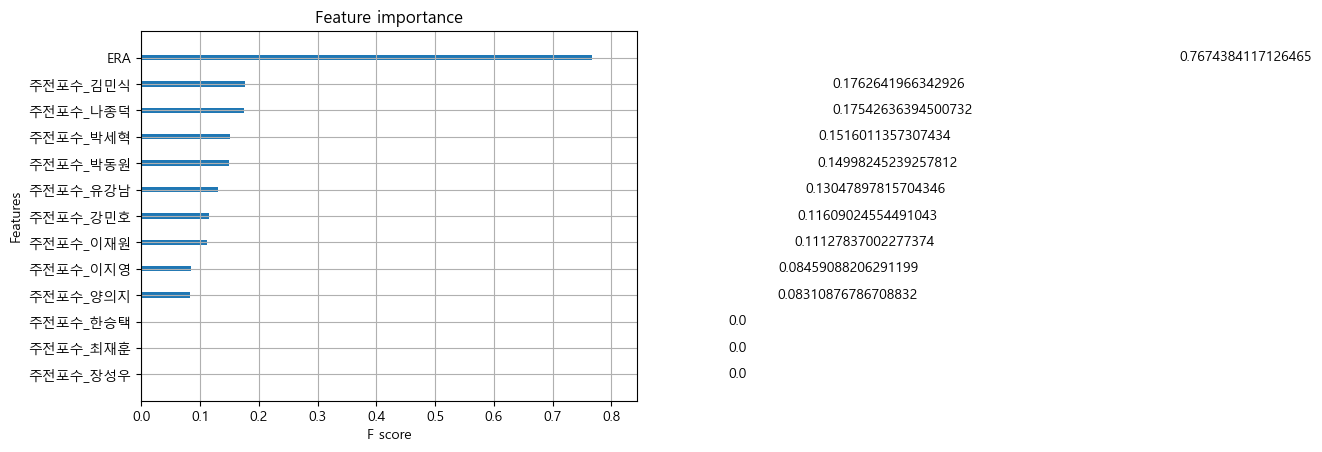

In [62]:
X = catch_pitch_0[['주전포수_강민호', '주전포수_김민식' ,'주전포수_나종덕', '주전포수_박동원', '주전포수_박세혁' ,'주전포수_양의지', '주전포수_유강남', '주전포수_이재원', '주전포수_이지영', '주전포수_장성우', '주전포수_최재훈', '주전포수_한승택', 'ERA']]
y = catch_pitch_0['FIP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
model = XGBRegressor(booster='gblinear')
model.fit(X_train, y_train)
plot_importance(model)
print(model.coef_)
print(model.intercept_)
print(model.score(X_train, y_train))

[0.0930766 0.0638491 0.0930766 0.118318  0.0322551 0.        0.0932269
 0.128395  0.14905   0.        0.        0.        0.707777 ]
[0.0868445]
0.5275504746279728


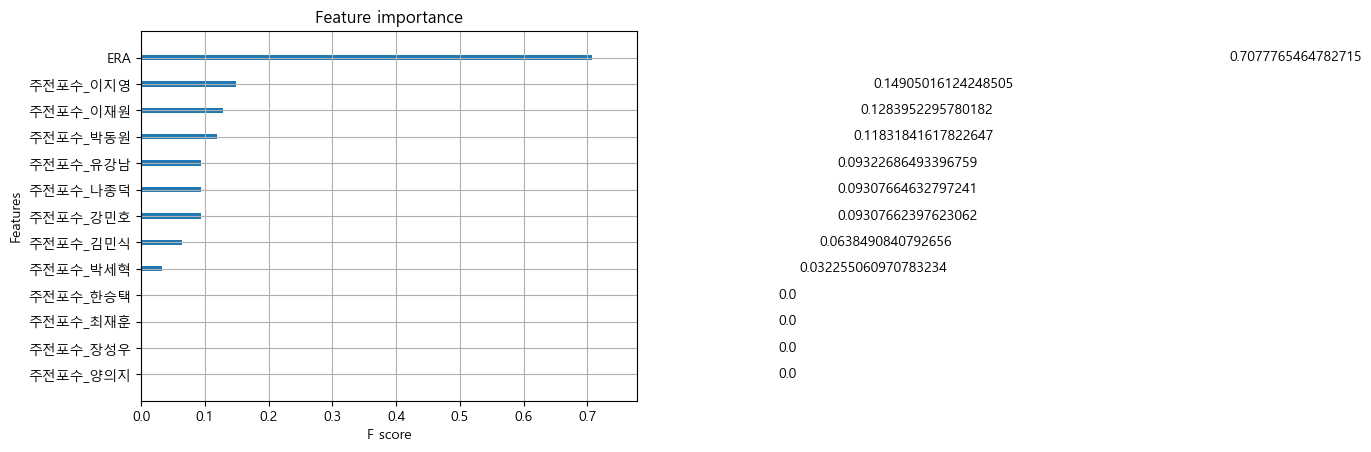

In [63]:
X = catch_pitch_1[['주전포수_강민호', '주전포수_김민식' ,'주전포수_나종덕', '주전포수_박동원', '주전포수_박세혁' ,'주전포수_양의지', '주전포수_유강남', '주전포수_이재원', '주전포수_이지영', '주전포수_장성우', '주전포수_최재훈', '주전포수_한승택', 'ERA']]
y = catch_pitch_1['FIP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
model = XGBRegressor(booster='gblinear')
model.fit(X_train, y_train)
plot_importance(model)
print(model.coef_)
print(model.intercept_)
print(model.score(X_train, y_train))

[0.105098  0.160815  0.0882287 0.0793714 0.0199524 0.089503  0.0859611
 0.0866346 0.0435974 0.        0.        0.        0.64596  ]
[0.0925161]
0.3755373234812047


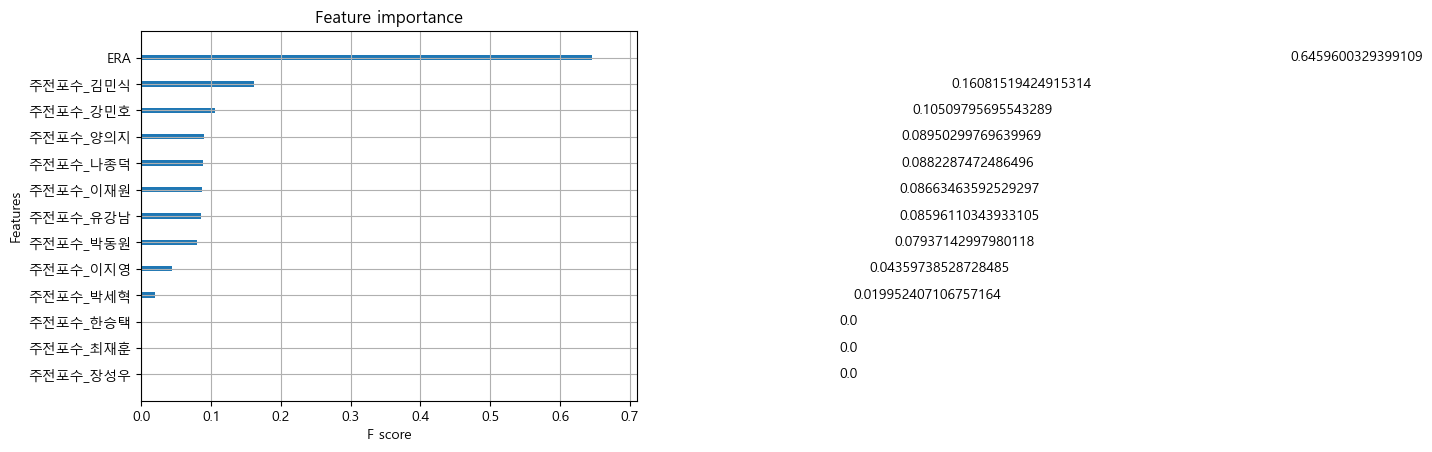

In [64]:
X = catch_pitch_2[['주전포수_강민호', '주전포수_김민식' ,'주전포수_나종덕', '주전포수_박동원', '주전포수_박세혁' ,'주전포수_양의지', '주전포수_유강남', '주전포수_이재원', '주전포수_이지영', '주전포수_장성우', '주전포수_최재훈', '주전포수_한승택', 'ERA']]
y = catch_pitch_2['FIP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
model = XGBRegressor(booster='gblinear')
model.fit(X_train, y_train)
plot_importance(model)
print(model.coef_)
print(model.intercept_)
print(model.score(X_train, y_train))

[0.101359 0.146788 0.181532 0.168006 0.146288 0.120608 0.155973 0.100256
 0.134349 0.       0.       0.       0.760845]
[0.130694]
0.5590578037608649


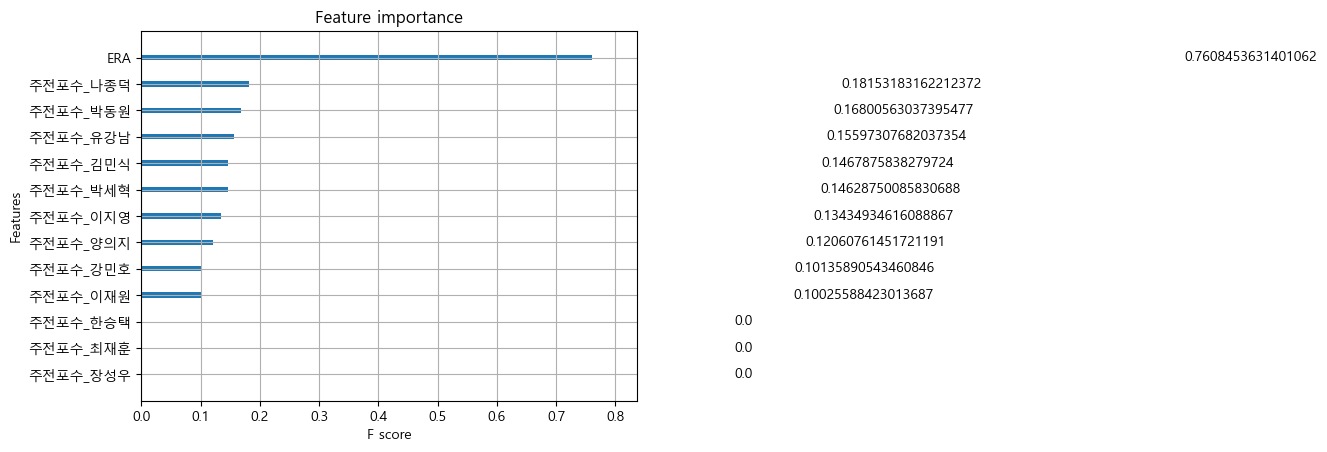

In [65]:
X = catch_pitch_3[['주전포수_강민호', '주전포수_김민식' ,'주전포수_나종덕', '주전포수_박동원', '주전포수_박세혁' ,'주전포수_양의지', '주전포수_유강남', '주전포수_이재원', '주전포수_이지영', '주전포수_장성우', '주전포수_최재훈', '주전포수_한승택', 'ERA']]
y = catch_pitch_3['FIP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
model = XGBRegressor(booster='gblinear')
model.fit(X_train, y_train)
plot_importance(model)
print(model.coef_)
print(model.intercept_)
print(model.score(X_train, y_train))

[0.11072   0.116997  0.141722  0.113324  0.113721  0.140746  0.112825
 0.0791939 0.118678  0.        0.        0.        0.808931 ]
[0.155407]
0.5644032979506415


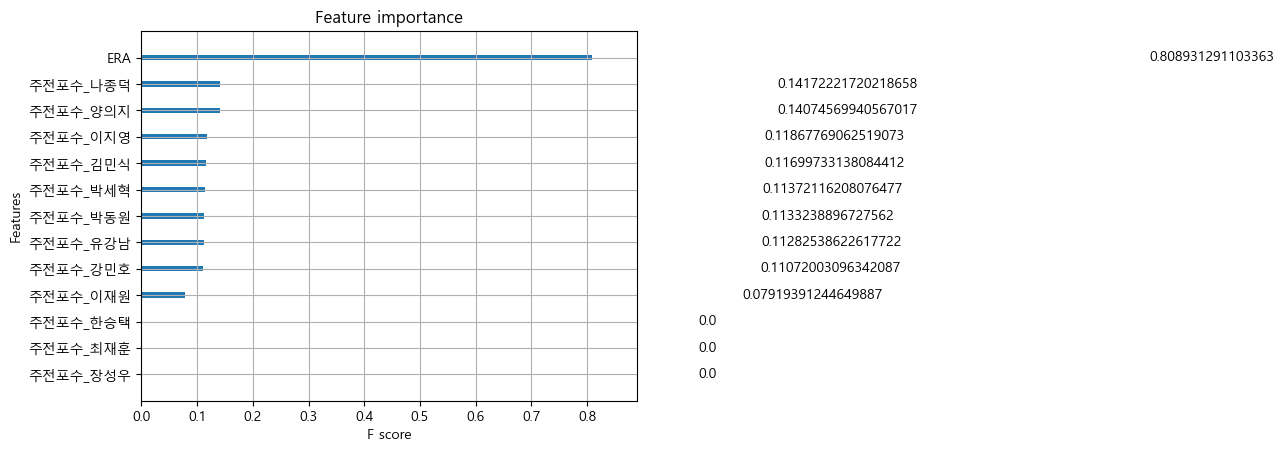

In [66]:
X = catch_pitch_4[['주전포수_강민호', '주전포수_김민식' ,'주전포수_나종덕', '주전포수_박동원', '주전포수_박세혁' ,'주전포수_양의지', '주전포수_유강남', '주전포수_이재원', '주전포수_이지영', '주전포수_장성우', '주전포수_최재훈', '주전포수_한승택', 'ERA']]
y = catch_pitch_4['FIP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
model = XGBRegressor(booster='gblinear')
model.fit(X_train, y_train)
plot_importance(model)
print(model.coef_)
print(model.intercept_)
print(model.score(X_train, y_train))